

Objetivo para a análise:
* criar indicador para a qualidade da brassagem em relação ao previsto
* criar ferramenta para 

Objetivo para o estudante:
* apresentar um passo a passo para a análise dos dados
* apresentar as principais ferramentas utilizadas na análise

In [60]:
# importação de bibliotecas que utilizaresmos

import numpy as np
import pandas as pd
import os
import pickle
from pathlib import Path
import epmwebapi as epm
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import datetime

In [61]:
# identificar o caminho presente projeto o da pasta de dados

cwd = os.getcwd()
project_folder = Path(cwd).parents[0]
dataset_folder = project_folder / 'data'

## Carregar os dados via epmwebapi

In [62]:
import getpass

user = input('EPM user:')
password = getpass.getpass("EPM password:")
epm_auth = 'http://epmtraining.northeurope.cloudapp.azure.com:44333'
epm_web  = 'http://epmtraining.northeurope.cloudapp.azure.com:44332'

# conecção com o EPM Server para coletarmos os dados
connection = epm.EpmConnection(epm_auth, epm_web, user, password)

EPM user:jonathan
EPM password:········


In [63]:
# seleção das tags que iremos utilizadar
tags = ['node01_stage', 'node01_temp2_ds18', 'node01_temp_sp']

# novo nome para as tags. Auxilia na análise 
tags_new = ['stage', 'temp', 'sp']

# período de coleta dos dados
ini_date = datetime.datetime(2020, 5, 17)
end_date = datetime.datetime(2020, 5, 18)

# coleta dos dados
bv = connection.getDataObjects(tags)
queryPeriod = epm.QueryPeriod(ini_date, end_date)

# transformação dos dados para pandas
data = {}
for t, t_new in zip(tags, tags_new):
    # carrega dos dados
    d = bv[t].historyReadRaw(queryPeriod)
    
    # transforma para DataFrame do Pandas
    new_Quality = d[:]['Quality'].byteswap().newbyteorder()
    new_Timestamp = d[:]['Timestamp']
    new_Value = d[:]['Value'].byteswap().newbyteorder()

    d_dict = {'value':new_Value, 'timestamp':new_Timestamp, 'quality':new_Quality}

    data[t_new] = pd.DataFrame(d_dict) 


# verificando os dados
data['temp'].head()

,value,timestamp,quality
0,12.13,2020-05-17 14:30:48+00:00,0
1,12.13,2020-05-17 14:30:49+00:00,0
2,12.13,2020-05-17 14:30:50+00:00,0
3,12.13,2020-05-17 14:30:53+00:00,0
4,12.13,2020-05-17 14:30:56+00:00,0


In [64]:
# savando os dados
pickle.dump(data, open(f'{dataset_folder}\\dados.p', "wb")) 

### OBS: Nesse ponto, é interessante salvar os dados para sempre retomar a análise deste ponto. 
# Isso evita que precisamos fazer novas consultas ao servidor e retransformar os dados para DataFrame.
# Esses operações podem ser muito lentas para grande bancos de dados.

## Carregar dados Salvos

In [65]:
data = pickle.load(open(f'{dataset_folder}\\dados.p', 'rb'))

## Visualização dos dados

In [66]:
fig = go.Figure([go.Scatter(x=data['sp']['timestamp'], y=data['sp']['value'], name='sp', line_shape='hv'),
                go.Scatter(x=data['temp']['timestamp'], y=data['temp']['value'], name='temp')])

fig.show()

### OBS: a biblioteca pyplot, utilizada para plotar esse gráfico, é excelente para se obter os primeiros insights dos dados.
# Aqui já podemos identificar os tipos de pré-processamentos e limpeza que precisaremos executar.
# Nesse caso, os dados são de boa qualidade, então não 

### Dados mais próximos do industrial

Geralmente os dados não têm um comportamente tão bom como esse. Dados indsutriais possuem:
* ruido
* distúrbio (tendência)
* outliers
* valores ausentes
* 

Os dados industriais são mais próximos dos plotados abaixo.

In [57]:
dados_limpos = data['temp']['value']
tamanho = len(data['temp']['value'])

# ruido - distribuição normal (Gaussiana)
noise = 5 * np.random.rand(tamanho)
dados_sujos = dados_limpos + noise
              
# outliers
n_outliers = 10
indice_outlier = np.random.randint(0, tamanho, size=n_outliers)
dados_sujos[indice_outlier] = dados_sujos[indice_outlier] + 30 * np.random.rand(n_outliers)

# 

fig = go.Figure([go.Scatter(x=data['temp']['timestamp'], y=dados_sujos, name='temp')])
fig.show()

## Análise básica

In [12]:
temp_data = data['temp']

temp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6421 entries, 0 to 6420
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   value      6421 non-null   float32            
 1   timestamp  6421 non-null   datetime64[ns, UTC]
 2   quality    6421 non-null   int64              
dtypes: datetime64[ns, UTC](1), float32(1), int64(1)
memory usage: 125.5 KB


In [13]:
temp_data.describe()

,value,quality
count,6421.000000,6421.0
mean,61.416985,0.0
std,25.635670,0.0
min,12.000000,0.0
25%,44.130001,0.0
50%,64.440002,0.0
75%,82.940002,0.0
max,95.620003,0.0


In [14]:
temp_data.nunique()

value        1227
timestamp    6421
quality         1
dtype: int64

In [15]:
temp_data['quality'].value_counts()

0    6421
Name: quality, dtype: int64

Algumas outras análises possíveis:


## Verificando hipoteses

### Hipotese 1 - a perda de calor durante o aquecimento é desprezível.

Como testar?
Se não existe perda de calor, o balanço de massa é 

Como ?
Se a curva de aquecimento é linear, não existe perda de calor


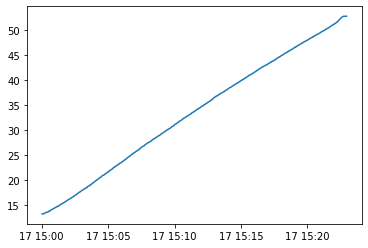

In [125]:
# período de aquecimento
inicio_aquec = np.datetime64('2020-05-17T15')
fim_aquec = np.datetime64('2020-05-17T15:23')

# seleção dos dados durante o aquecimento
ind = (temp_data['timestamp'].values > inicio_aquec) & (temp_data['timestamp'].values < fim_aquec)
temp_data_aquec = temp_data[ind]

plt.plot(temp_data_aque['timestamp'], temp_data_aque['value'])
plt.show()

### OBS: Para plots rápidos, é melhor utilizar o matpltlib por dois motivos: mais rápido/fácil de escrever o código e mais rápido para plotar os dados.
### OBS: É sempre bom verificar os dados após alguma operação. Se alguma coisa está errada, é mais fácil de se corrigir agora, que mais tarde.

score:  0.9989749188003386
T(C°) = 13.108090229463816 + 1.7603626306024236 * tempo (min)


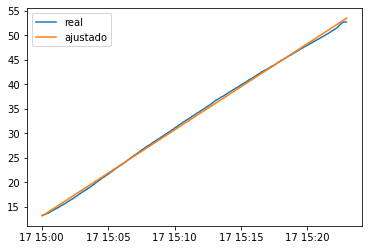

In [124]:
X = temp_data_aquec['timestamp'].values
y = temp_data_aquec['value'].values


# regressão não aceita valores do tipo datetime, então precisamos transformar para numérico
X = X - X[0] # diferença para o primeiro timestamp
X = X.astype('float64') / (1e9 * 60) # conversão para minutos do tipo float
X = [[x] for x in X] # transformação para matrix 2D, como exigido pelo scikitlearn


reg = LinearRegression()
reg.fit(X, y) # ajuste

print('score: ', reg.score(X, y))
print(f'T(C°) = {reg.intercept_} + {reg.coef_[0]} * tempo (min)')

y_pred = reg.predict(X)

# gráfico
plt.plot(temp_data_aque['timestamp'], y, label='real')
plt.plot(temp_data_aque['timestamp'], y_pred, label='ajustado')
plt.legend()
plt.show()

## Entregas para o cliente